In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
import os
from glob import glob
from copy import copy
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
random_seed = 0
np.random.seed(random_seed)

In [4]:
!ls -lh ../input

total 5.8M
-rw-r--r-- 1 root root 6.9K Dec 28 05:11 breed_labels.csv
-rw-r--r-- 1 root root   88 Dec 28 05:11 color_labels.csv
-rw-r--r-- 1 root root  285 Dec 28 05:11 state_labels.csv
drwxr-xr-x 2 root root 4.0K Dec 28 05:11 test
drwxr-xr-x 2 root root 520K Dec 28 05:14 test_images
drwxr-xr-x 2 root root 544K Dec 28 05:17 test_metadata
drwxr-xr-x 2 root root 132K Dec 28 05:18 test_sentiment
drwxr-xr-x 2 root root 4.0K Dec 28 05:18 train
drwxr-xr-x 2 root root 2.0M Dec 28 05:32 train_images
drwxr-xr-x 2 root root 2.1M Dec 28 05:46 train_metadata
drwxr-xr-x 2 root root 496K Dec 28 05:50 train_sentiment


In [5]:
all_data = pd.read_csv('../input/train/train.csv')
list(all_data.columns)

['Type',
 'Name',
 'Age',
 'Breed1',
 'Breed2',
 'Gender',
 'Color1',
 'Color2',
 'Color3',
 'MaturitySize',
 'FurLength',
 'Vaccinated',
 'Dewormed',
 'Sterilized',
 'Health',
 'Quantity',
 'Fee',
 'State',
 'RescuerID',
 'VideoAmt',
 'Description',
 'PetID',
 'PhotoAmt',
 'AdoptionSpeed']

In [6]:
pet_data = all_data.set_index('PetID')
image_data = []

for image in glob('../input/train_images/*.jpg'):
    basename = os.path.basename(image)
    pet_id, _ = basename.rsplit('-')
    pet_row = pet_data.loc[pet_id].to_dict()
    pet_row['ImageFilename'] = image
    pet_row['ImageBasename'] = basename
    image_data.append(pet_row)
    
image_data = pd.DataFrame(image_data)
image_data['AdoptionSpeed']= image_data['AdoptionSpeed'].astype(str)
image_data.head(2)

,AdoptionSpeed,Age,Breed1,Breed2,Color1,Color2,Color3,Description,Dewormed,Fee,FurLength,Gender,Health,ImageBasename,ImageFilename,MaturitySize,Name,PhotoAmt,Quantity,RescuerID,State,Sterilized,Type,Vaccinated,VideoAmt
0,1,120,20,195,2,0,0,2 males beagle & schnauzer for adoption. 10 & ...,1,0,1,1,1,8e0d65b3e-1.jpg,../input/train_images/8e0d65b3e-1.jpg,2,NaN,1.0,2,310cd86ec76858f026b95e421b833294,41326,2,1,1,0
1,3,8,266,0,1,2,7,Stray cat-Female 8mths. already spayed her on ...,1,0,1,2,1,6c9aeeb27-2.jpg,../input/train_images/6c9aeeb27-2.jpg,2,Kitten RA9,3.0,1,b770bac0ca797cf1433c48a35d30c4cb,41401,1,2,1,0


In [7]:
len(image_data), len(pet_data)

(58311, 14993)

In [8]:
y = image_data['AdoptionSpeed']
test_size = 0.2
validation_size = 0.2

# Split the training data off from leftover (i.e. validation and testing)
# train_test_split(*arrays, **options)
# random_state is the seed used by the random number generator
# data is split in a stratified fashion, using this as the class labels
X_train, X_leftover, y_train, y_leftover = train_test_split(
    image_data, y, test_size=test_size, random_state=random_seed,
    stratify=y.values # stratify to ensure equal distribution of classes
)

# Determine how much the leftover section should be split to test
test_split = test_size / (test_size + validation_size)

X_validate, X_test, y_validate, y_test = train_test_split(
    X_leftover, y_leftover, test_size=test_split, random_state=random_seed,
    stratify=y_leftover.values # stratify to ensure equal distribution of classes
)

X_train.shape, X_validate.shape, X_test.shape

((46648, 25), (5831, 25), (5832, 25))

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
BATCH_SIZE = 20
image_data.dtypes

AdoptionSpeed     object
Age                int64
Breed1             int64
Breed2             int64
Color1             int64
Color2             int64
Color3             int64
Description       object
Dewormed           int64
Fee                int64
FurLength          int64
Gender             int64
Health             int64
ImageBasename     object
ImageFilename     object
MaturitySize       int64
Name              object
PhotoAmt         float64
Quantity           int64
RescuerID         object
State              int64
Sterilized         int64
Type               int64
Vaccinated         int64
VideoAmt           int64
dtype: object

In [11]:
# Generate batches of tensor image data with real-time data augmentation. 
# The data will be looped over (in batches).

train_generator = train_datagen.flow_from_dataframe(
    X_train.reset_index(), # Need to reset index due to bug in flow_from_dataframe
    directory='../input/train_images/',
    x_col='ImageBasename',
    y_col='AdoptionSpeed',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
)

val_generator = val_datagen.flow_from_dataframe(
    X_validate.reset_index(), # Need to reset index due to bug in flow_from_dataframe
    directory='../input/train_images/',
    x_col='ImageBasename',
    y_col='AdoptionSpeed',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
)

Found 46648 images belonging to 5 classes.
Found 5831 images belonging to 5 classes.


In [12]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model

In [13]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2019-04-09 15:05:18--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  77.5MB/s    in 1.1s    

2019-04-09 15:05:20 (77.5 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(224, 224, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [16]:
last_layer = pre_trained_model.get_layer('mixed7')
print ('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 12, 12, 768)


In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [18]:
# import regularizer
from keras.regularizers import l1
# instantiate regularizer
reg = l1(0.001)

# example of l1 norm on activity from a cnn layer
from keras.layers import Conv2D
from keras.regularizers import l1

In [19]:
from keras import regularizers


In [20]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01), 
                 activity_regularizer=l1(0.001))(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(5, activation='softmax')(x)

# Dropout is a a technique used to tackle Overfitting . 
# The Dropout method in keras.layers module takes in a 
# float between 0 and 1, which is the fraction of the 
# neurons to drop. 

# Configure and compile the model
model = Model(pre_trained_model.input, x)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

In [22]:
steps_train = len(X_train)//BATCH_SIZE
steps_val = len(X_validate)//BATCH_SIZE


In [23]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=steps_train,
      epochs=10,
      validation_data=val_generator,
      validation_steps=steps_val,
      workers=4,
      use_multiprocessing=True,
      shuffle=True,
      verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
2333/2333 [==============================] - 715s 307ms/step - loss: 21.7854 - acc: 0.2676 - val_loss: 21.6533 - val_acc: 0.2771
Epoch 2/10
2333/2333 [==============================] - 699s 300ms/step - loss: 21.5253 - acc: 0.2749 - val_loss: 21.4309 - val_acc: 0.2864
Epoch 3/10
 628/2333 [=======>......................] - ETA: 8:03 - loss: 21.3937 - acc: 0.2829

In [24]:
predictions = model.predict_generator(val_generator, steps=steps_val)

In [25]:
val_preds = np.argmax(predictions, axis=-1)
val_trues = val_generator.classes

In [26]:
#cm = confusion_matrix(val_trues, val_preds)
class_names = ['1','2','3','4','5']

In [27]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [28]:
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[   0    4   95   18   20]
 [   0   32  734  222  163]
 [   0   58 1028  315  243]
 [   0   55  941  304  206]
 [   0   34  867  277  215]]


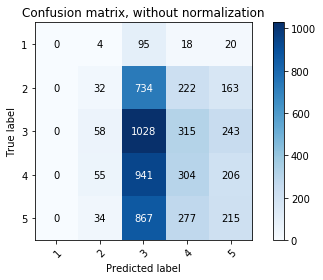

In [29]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(val_trues, val_preds, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.   0.03 0.69 0.13 0.15]
 [0.   0.03 0.64 0.19 0.14]
 [0.   0.04 0.63 0.19 0.15]
 [0.   0.04 0.62 0.2  0.14]
 [0.   0.02 0.62 0.2  0.15]]


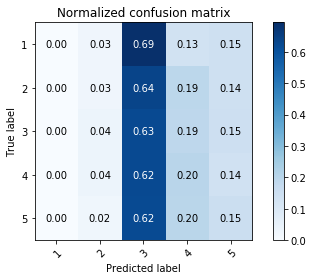

In [30]:
# Plot normalized confusion matrix
plot_confusion_matrix(val_trues, val_preds, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [31]:
plt.show()

In [32]:
#labels = val_generator.class_indices.keys()
#precisions, recall, f1_score, _ = precision_recall_fscore_support(val_trues, val_preds, labels=labels)

Text(0.5, 1.0, 'Training and validation loss')

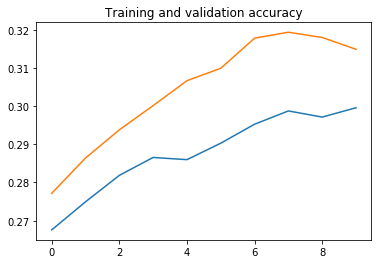

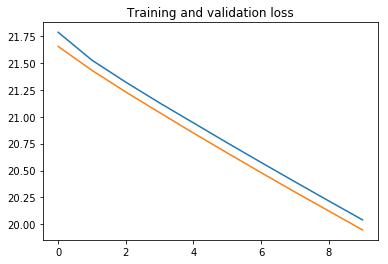

In [33]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')